# Skin Disease Detection using Mobile Application
## Final Year Project 2
Ahmad Daniel Ikhwan Bin Rosli <br>
1201103071

In [44]:
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [2]:
# kaggle.json path
# os.environ['PATH'] += os.pathsep + r'C:\Users\ADMIN\AppData\Roaming\Microsoft\Windows\Recent\kaggle.json.lnk'

In [3]:
# download dataset
# !kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification -p datasets/ham10000_raw --unzip

### Prep

In [4]:
# create label
df = pd.read_csv("datasets/ham10000_raw/GroundTruth.csv")
df["label"] = df[["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]].idxmax(axis=1).str.lower()
df = df[df["label"].isin(["mel", "nv", "bcc", "akiec", "bkl", "df", "vasc"])].reset_index(drop=True)
df["file_path"] = df["image"].apply(lambda x: f"datasets/ham10000_raw/images/{x}.jpg")
display(df)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,file_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets/ham10000_raw/images/ISIC_0024306.jpg
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets/ham10000_raw/images/ISIC_0024307.jpg
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets/ham10000_raw/images/ISIC_0024308.jpg
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets/ham10000_raw/images/ISIC_0024309.jpg
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mel,datasets/ham10000_raw/images/ISIC_0024310.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mel,datasets/ham10000_raw/images/ISIC_0034316.jpg
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mel,datasets/ham10000_raw/images/ISIC_0034317.jpg
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,bkl,datasets/ham10000_raw/images/ISIC_0034318.jpg
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets/ham10000_raw/images/ISIC_0034319.jpg


In [5]:
# drop col
df_drop = df.drop(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"], axis=1)
display(df_drop)


,label,file_path
0,nv,datasets/ham10000_raw/images/ISIC_0024306.jpg
1,nv,datasets/ham10000_raw/images/ISIC_0024307.jpg
2,nv,datasets/ham10000_raw/images/ISIC_0024308.jpg
3,nv,datasets/ham10000_raw/images/ISIC_0024309.jpg
4,mel,datasets/ham10000_raw/images/ISIC_0024310.jpg
...,...,...
10010,mel,datasets/ham10000_raw/images/ISIC_0034316.jpg
10011,mel,datasets/ham10000_raw/images/ISIC_0034317.jpg
10012,bkl,datasets/ham10000_raw/images/ISIC_0034318.jpg
10013,nv,datasets/ham10000_raw/images/ISIC_0034319.jpg


In [6]:
# count each class images
target_classes = ["mel", "nv", "bcc", "bkl", "akiec", "df", "vasc"]
df_drop = df_drop[df_drop["label"].isin(target_classes)].reset_index(drop=True)
df_drop["label"].value_counts()

label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [7]:
# Parameters
target_count = 6000
img_size = (224, 224)
train_dir = Path("datasets/augmented_data/train")
original_dir = Path("datasets/augmented_data/original")

# Clean old data
for path in [train_dir, original_dir]:
    if path.exists():
        shutil.rmtree(path)
    for label in df_drop["label"].unique():
        (path / label).mkdir(parents=True, exist_ok=True)

# Augmentor setup
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# Generate data per class
for label in tqdm([l for l in df_drop["label"].unique() if l != "nv"], desc="Augmenting each class to 6000"):
    class_df = df_drop[df_drop["label"] == label]
    original_paths = class_df["file_path"].tolist()

    # Save original images (for val/test)
    if label != "nv":
        for img_path in original_paths:
            img = load_img(img_path, target_size=img_size)
            save_img(str(original_dir / label / Path(img_path).name), img)

    # Augment images until total reaches 6000
    count = 0
    if label != "nv":
        while count < (target_count - len(original_paths)):
            for path in original_paths:
                img = load_img(path, target_size=img_size)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                aug_iter = augmentor.flow(x, batch_size=1)
                aug_img = next(aug_iter)[0].astype(np.uint8)
                aug_name = f"{Path(path).stem}_aug_{count}.jpg"
                save_img(str(train_dir / label / aug_name), aug_img)
                count += 1
                if count >= (target_count - len(original_paths)):
                    break

Augmenting each class to 6000: 100%|██████████| 6/6 [06:56<00:00, 69.48s/it]


In [11]:
original_dir = Path("datasets/augmented_data/original")
val_dir = Path("datasets/augmented_data/val")
test_dir = Path("datasets/augmented_data/test")

# Clean existing val/test directories
for path in [val_dir, test_dir]:
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

# Split 50/50 into val and test for each class in original/
for label in os.listdir(original_dir):
    image_paths = list((original_dir / label).glob("*.jpg"))

    if len(image_paths) == 0:
        continue  # Skip empty folders like 'nv'

    # Create class subfolders
    (val_dir / label).mkdir(parents=True, exist_ok=True)
    (test_dir / label).mkdir(parents=True, exist_ok=True)

    val_imgs, test_imgs = train_test_split(image_paths, test_size=0.5, random_state=42)

    for img in val_imgs:
        shutil.copy(img, val_dir / label / img.name)
    for img in test_imgs:
        shutil.copy(img, test_dir / label / img.name)


In [12]:
# Filter only existing file paths for 'nv'
nv_paths = [
    Path(p) for p in df_drop[df_drop["label"] == "nv"]["file_path"].tolist()
    if Path(p).exists()
]

# 80/10/10 split
train_nv, val_test_nv = train_test_split(nv_paths, test_size=0.2, random_state=42)
val_nv, test_nv = train_test_split(val_test_nv, test_size=0.5, random_state=42)

# Copy nv images into their folders
for split_name, image_list in [("train", train_nv), ("val", val_nv), ("test", test_nv)]:
    dest = Path(f"datasets/augmented_data/{split_name}/nv")
    dest.mkdir(parents=True, exist_ok=True)
    for path in image_list:
        img = load_img(path, target_size=(224, 224))
        save_img(str(dest / path.name), img)

In [13]:
# Create generator
img_size = (224, 224)
batch_size = 32

# Only normalization here, no augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "datasets/augmented_data/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    "datasets/augmented_data/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    "datasets/augmented_data/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 38054 images belonging to 7 classes.
Found 2323 images belonging to 7 classes.
Found 2328 images belonging to 7 classes.


### Train 

In [14]:
def build_and_train_model(base_model_class, model_name, train_gen, val_gen, num_classes=7, epochs=50):
    print(f"Training {model_name}...")

    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        validation_steps=val_gen.samples // val_gen.batch_size,
        callbacks=[es],
        verbose=1
    )

    model.save(f"{model_name}_skin_disease.h5")
    return model, history

In [15]:
mobilenet_model, mobilenet_history = build_and_train_model(MobileNet, "mobilenet", train_gen, val_gen)

Training mobilenet...
Epoch 1/50
1189/1189 [==============================] - 357s 298ms/step - loss: 1.0862 - accuracy: 0.6038 - val_loss: 1.2512 - val_accuracy: 0.5104
Epoch 2/50
1189/1189 [==============================] - 48s 40ms/step - loss: 0.7635 - accuracy: 0.7234 - val_loss: 1.1937 - val_accuracy: 0.5260
Epoch 3/50
1189/1189 [==============================] - 48s 40ms/step - loss: 0.6565 - accuracy: 0.7643 - val_loss: 1.1456 - val_accuracy: 0.5525
Epoch 4/50
1189/1189 [==============================] - 48s 40ms/step - loss: 0.5859 - accuracy: 0.7900 - val_loss: 1.1514 - val_accuracy: 0.5551
Epoch 5/50
1189/1189 [==============================] - 49s 41ms/step - loss: 0.5342 - accuracy: 0.8099 - val_loss: 1.2193 - val_accuracy: 0.5365
Epoch 6/50
1189/1189 [==============================] - 50s 42ms/step - loss: 0.4954 - accuracy: 0.8254 - val_loss: 1.1047 - val_accuracy: 0.5773
Epoch 7/50
1189/1189 [==============================] - 51s 43ms/step - loss: 0.4593 - accuracy: 0.8

In [16]:
mobilenetv2_model, mobilenetv2_history = build_and_train_model(MobileNetV2, "mobilenetv2", train_gen, val_gen)

Training mobilenetv2...
Epoch 1/50
1189/1189 [==============================] - 60s 48ms/step - loss: 1.0726 - accuracy: 0.6086 - val_loss: 1.3195 - val_accuracy: 0.4970
Epoch 2/50
1189/1189 [==============================] - 56s 47ms/step - loss: 0.7762 - accuracy: 0.7193 - val_loss: 1.3011 - val_accuracy: 0.4996
Epoch 3/50
1189/1189 [==============================] - 56s 47ms/step - loss: 0.6744 - accuracy: 0.7581 - val_loss: 1.3004 - val_accuracy: 0.5148
Epoch 4/50
1189/1189 [==============================] - 56s 47ms/step - loss: 0.6064 - accuracy: 0.7839 - val_loss: 1.2643 - val_accuracy: 0.5256
Epoch 5/50
1189/1189 [==============================] - 58s 49ms/step - loss: 0.5564 - accuracy: 0.8022 - val_loss: 1.2809 - val_accuracy: 0.5304
Epoch 6/50
1189/1189 [==============================] - 56s 47ms/step - loss: 0.5146 - accuracy: 0.8174 - val_loss: 1.3155 - val_accuracy: 0.5200
Epoch 7/50
1189/1189 [==============================] - 56s 47ms/step - loss: 0.4813 - accuracy: 0.8

In [17]:
mobilenetv3_model, mobilenetv3_history = build_and_train_model(MobileNetV3Small, "mobilenetv3small", train_gen, val_gen)

Training mobilenetv3small...
Epoch 1/50
1189/1189 [==============================] - 59s 47ms/step - loss: 1.9447 - accuracy: 0.1566 - val_loss: 1.9941 - val_accuracy: 0.0304
Epoch 2/50
1189/1189 [==============================] - 49s 41ms/step - loss: 1.9428 - accuracy: 0.1623 - val_loss: 2.0076 - val_accuracy: 0.0399
Epoch 3/50
1189/1189 [==============================] - 50s 42ms/step - loss: 1.9407 - accuracy: 0.1721 - val_loss: 1.9652 - val_accuracy: 0.0356
Epoch 4/50
1189/1189 [==============================] - 50s 42ms/step - loss: 1.9390 - accuracy: 0.1801 - val_loss: 1.9964 - val_accuracy: 0.0260
Epoch 5/50
1189/1189 [==============================] - 50s 42ms/step - loss: 1.9367 - accuracy: 0.1830 - val_loss: 2.0016 - val_accuracy: 0.0252
Epoch 6/50
1189/1189 [==============================] - 49s 41ms/step - loss: 1.9346 - accuracy: 0.1961 - val_loss: 1.9682 - val_accuracy: 0.0382
Epoch 7/50
1189/1189 [==============================] - 49s 41ms/step - loss: 1.9322 - accuracy

### Evaluate

In [18]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.show()


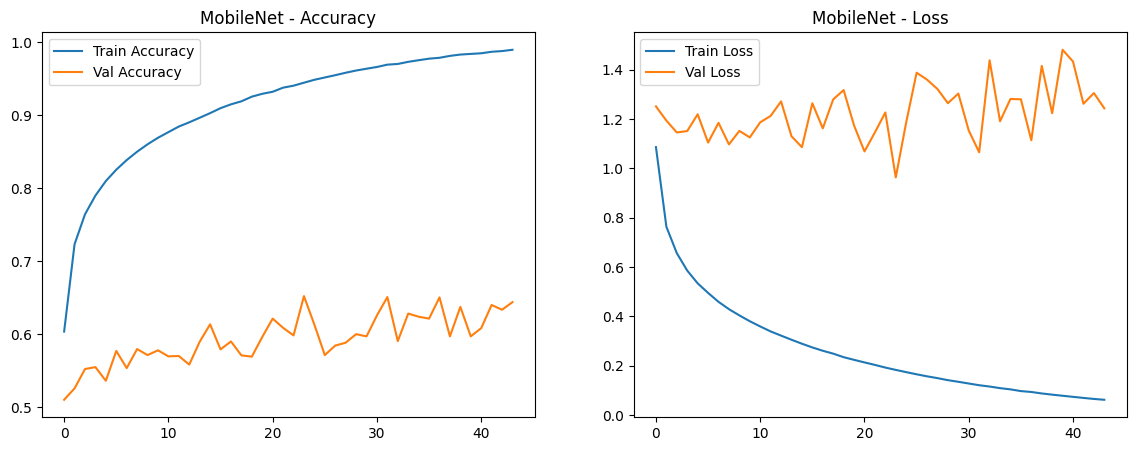

In [19]:

plot_history(mobilenet_history, "MobileNet")


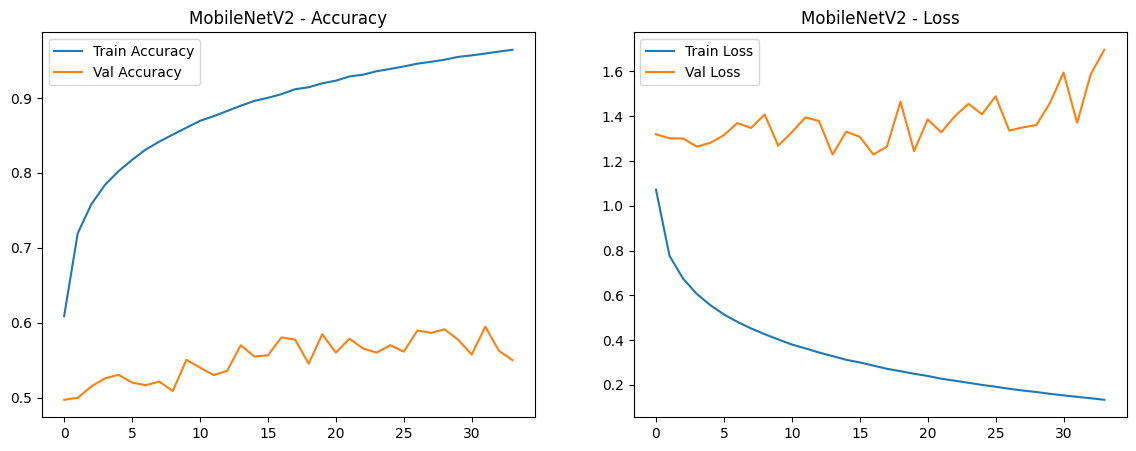

In [20]:
plot_history(mobilenetv2_history, "MobileNetV2")


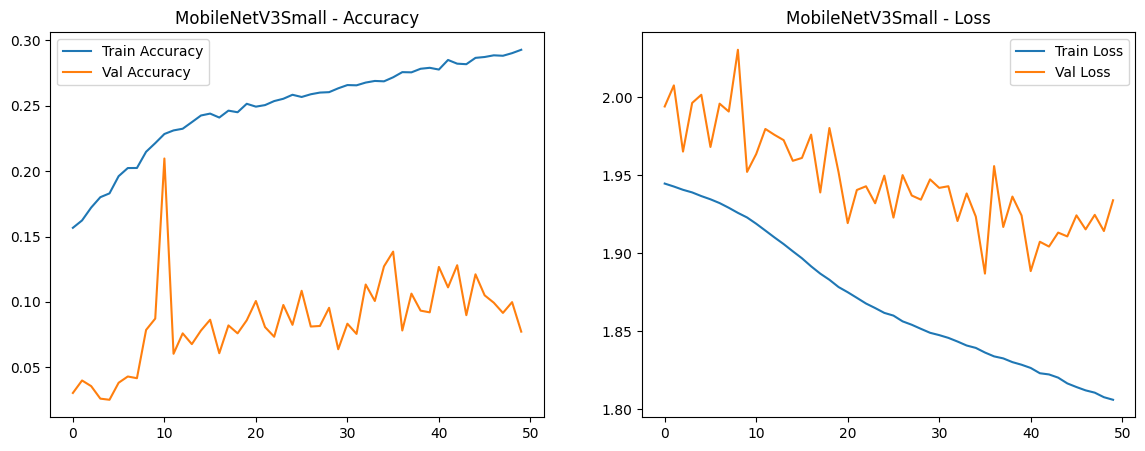

In [21]:
plot_history(mobilenetv3_history, "MobileNetV3Small")

In [22]:
print("MobileNet:")
mobilenet_model.evaluate(test_gen)

MobileNet:
73/73 [==============================] - 20s 280ms/step - loss: 0.9887 - accuracy: 0.6460


[0.9886686205863953, 0.6460481286048889]

In [23]:
print("MobileNetV2:")
mobilenetv2_model.evaluate(test_gen)

MobileNetV2:
73/73 [==============================] - 4s 47ms/step - loss: 1.2796 - accuracy: 0.5533


[1.2796015739440918, 0.5532646179199219]

In [24]:
print("MobileNetV3Small:")
mobilenetv3_model.evaluate(test_gen)

MobileNetV3Small:
73/73 [==============================] - 4s 47ms/step - loss: 1.9396 - accuracy: 0.0760


[1.9396121501922607, 0.0760309249162674]

In [36]:
def evaluate_model(model, test_gen, model_name):
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    labels = list(test_gen.class_indices.keys())

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


73/73 [==============================] - 3s 45ms/step

MobileNet Classification Report:
              precision    recall  f1-score   support

       akiec       0.87      0.64      0.74       164
         bcc       0.85      0.67      0.75       257
         bkl       0.75      0.52      0.61       550
          df       0.68      0.86      0.76        58
         mel       0.79      0.42      0.55       557
          nv       0.50      0.88      0.64       671
        vasc       0.90      0.93      0.92        71

    accuracy                           0.65      2328
   macro avg       0.76      0.70      0.71      2328
weighted avg       0.71      0.65      0.64      2328



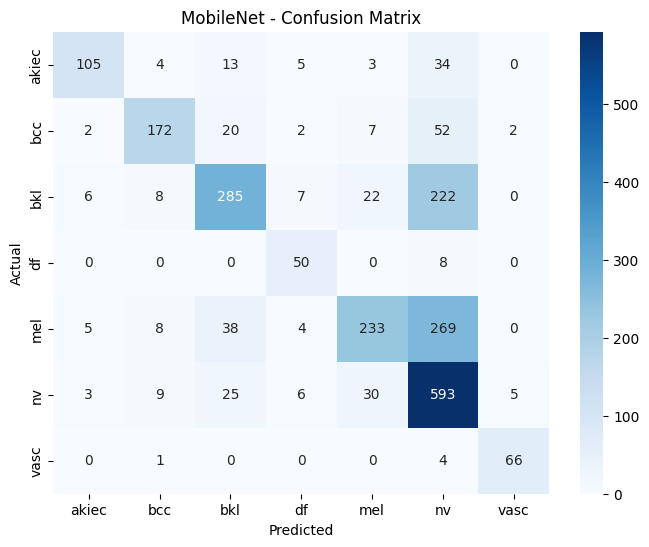

In [37]:
evaluate_model(mobilenet_model, test_gen, "MobileNet")


73/73 [==============================] - 3s 41ms/step

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.70      0.68       164
         bcc       0.83      0.55      0.66       257
         bkl       0.71      0.30      0.43       550
          df       0.54      0.64      0.58        58
         mel       0.74      0.29      0.41       557
          nv       0.43      0.90      0.58       671
        vasc       0.89      0.94      0.92        71

    accuracy                           0.55      2328
   macro avg       0.69      0.62      0.61      2328
weighted avg       0.65      0.55      0.53      2328



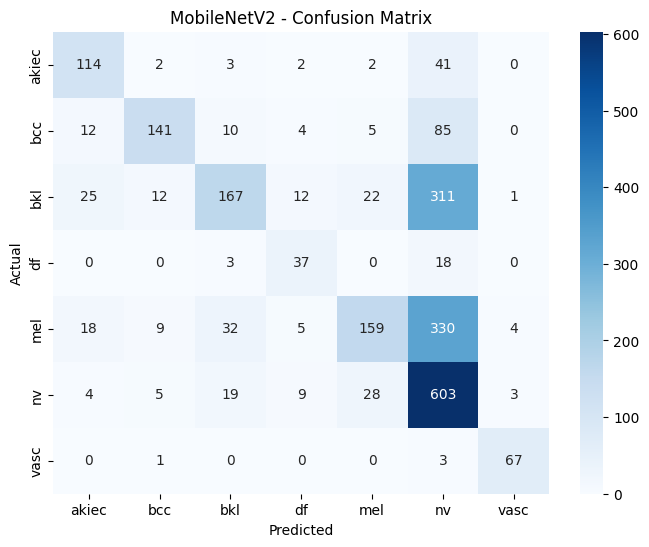

In [38]:
evaluate_model(mobilenetv2_model, test_gen, "MobileNetV2")


73/73 [==============================] - 3s 42ms/step

MobileNetV3Small Classification Report:
              precision    recall  f1-score   support

       akiec       0.13      0.23      0.17       164
         bcc       0.00      0.00      0.00       257
         bkl       0.00      0.00      0.00       550
          df       0.04      0.78      0.07        58
         mel       0.50      0.01      0.01       557
          nv       0.45      0.06      0.11       671
        vasc       0.07      0.66      0.13        71

    accuracy                           0.08      2328
   macro avg       0.17      0.25      0.07      2328
weighted avg       0.26      0.08      0.05      2328



c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


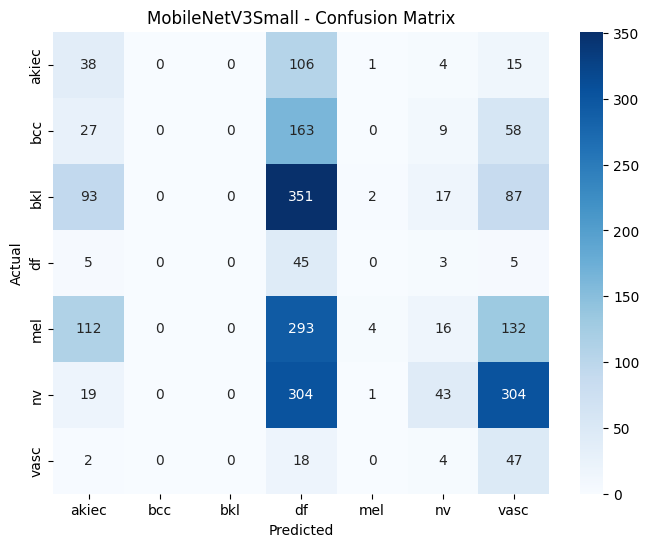

In [39]:
evaluate_model(mobilenetv3_model, test_gen, "MobileNetV3Small")

In [40]:
def measure_avg_inference_time(model, sample_path, model_name, runs=5):
    img = image.load_img(sample_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    times = []
    for _ in range(runs):
        start = time.time()
        _ = model.predict(img_array)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    print(f"{model_name} Avg Inference Time over {runs} runs: {avg_time:.4f} sec")

# Provide a real test image path
sample_image = "datasets/augmented_data/test/nv/ISIC_0024401.jpg"

In [41]:
measure_avg_inference_time(mobilenet_model, sample_image, "MobileNet")

1/1 [==============================] - 0s 22ms/step
MobileNet Avg Inference Time over 5 runs: 0.0603 sec


In [42]:
measure_avg_inference_time(mobilenetv2_model, sample_image, "MobileNetV2")

1/1 [==============================] - 0s 27ms/step
MobileNetV2 Avg Inference Time over 5 runs: 0.0615 sec


In [43]:
measure_avg_inference_time(mobilenetv3_model, sample_image, "MobileNetV3Small")

1/1 [==============================] - 0s 32ms/step
MobileNetV3Small Avg Inference Time over 5 runs: 0.0695 sec


### Convert

In [45]:
model = load_model("mobilenet_skin_disease.h5")

# Convert the Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open("mobilenet_skin_disease.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpszq7gy9_\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpszq7gy9_\assets
